## Download soilgrids SOC data and propagate uncertainty across 0-5cm, 5-15cm, and 15-30cm layers

Serge Wiltshire, 5/13/24

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from soilgrids import SoilGrids
import rasterio as rio  
soil_grids = SoilGrids()

Function to download soilgrids data

In [3]:
def dl_sg(cov):
    sg_data = soil_grids.get_coverage_data(
        service_id='soc',
        coverage_id=cov,
        west=-19949000.0, #-1784000,
        south=-6147500.0, #1356000,
        east=19861750.0, #-1140000,
        north=8361000.0, #1863000,
        resx=3000, # max size of raster is apparently 16384 pixels in each direction, so this (3km) is essentially the max resolution...
        resy=3000,
        crs="urn:ogc:def:crs:EPSG::152160",
        output = cov + ".tif",
        local_file=False # if true, loads a previously saved tif named same as above
    )
    return sg_data


Function to convert to soilgrids class to 2d numpy array

In [4]:
def sg_to_np(sg_data):
    np_data = sg_data.values
    np_data = np_data.reshape(np_data.shape[1], np_data.shape[2]).astype('float') # reshape to 2d
    np_data[np_data == sg_data._FillValue] = np.nan # replace fill value (used for water, etc.) with nan
    return np_data

Functions to plot numpy data

In [5]:
def plot_np_sg(np_data, filename):
    plt.imshow(np_data, cmap = 'viridis' , interpolation = 'none')
    plt.axis('off')
    plt.colorbar()
    fig = plt.gcf()
    fig.set_size_inches(11,3)
    # plt.show()
    fig.savefig(filename + '.png', bbox_inches='tight', dpi=600)
    plt.close("all")

# plot_np_sg(np_data_dict['soc_0-5cm_mean'], 'null')

def plot_hist(data, label):
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    
    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram: ' + label)
    
    # Display the plot
    plt.show()

Coverages (maps) we're interested in

In [6]:
covs = ['soc_0-5cm_mean', 'soc_0-5cm_uncertainty', 
        'soc_5-15cm_mean', 'soc_5-15cm_uncertainty', 
        'soc_15-30cm_mean', 'soc_15-30cm_uncertainty']

Do the downloads and conversions

In [7]:
# sg_data_dict = {}

# for cov in covs:
#     print('Downloading SG data: ' + cov)
#     sg_data_dict[f"{cov}"] = dl_sg(cov)


Save downloaded data to pickle

In [8]:
# with open("sg_data_dict.p", "wb") as file:
#     pickle.dump(sg_data_dict, file)

Load downloaded data from pickle

In [9]:
with open('sg_data_dict.p', 'rb') as file:
    sg_data_dict = pickle.load(file)

Convert tif to numpy

In [10]:
np_data_dict = {}

for key, value in sg_data_dict.items():
    print('Converting SG data to Numpy: ' + key)
    np_data_dict[key] = sg_to_np(value)

Converting SG data to Numpy: soc_0-5cm_mean
Converting SG data to Numpy: soc_0-5cm_uncertainty
Converting SG data to Numpy: soc_5-15cm_mean
Converting SG data to Numpy: soc_5-15cm_uncertainty
Converting SG data to Numpy: soc_15-30cm_mean
Converting SG data to Numpy: soc_15-30cm_uncertainty


Plot each to make sure we're on the right track

In [112]:
for key, value in np_data_dict.items():
    print('Plotting ' + key)
    plot_np_sg(value, key)

Plotting soc_0-5cm_mean
Plotting soc_0-5cm_uncertainty
Plotting soc_5-15cm_mean
Plotting soc_5-15cm_uncertainty
Plotting soc_15-30cm_mean
Plotting soc_15-30cm_uncertainty


Flatten each 2d array to vector

In [11]:
np_data_dict_flat = np_data_dict.copy()

for key in np_data_dict_flat:
    print(np_data_dict_flat[key].shape)
    np_data_dict_flat[key] = np_data_dict_flat[key].flatten()
    print(np_data_dict_flat[key].shape)

# store vector length for later
vec_len = 64173720

(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)


Plot histograms of uncertainty vectors as reported

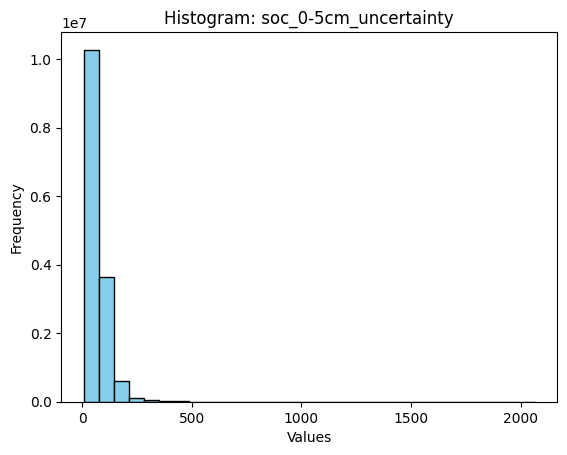

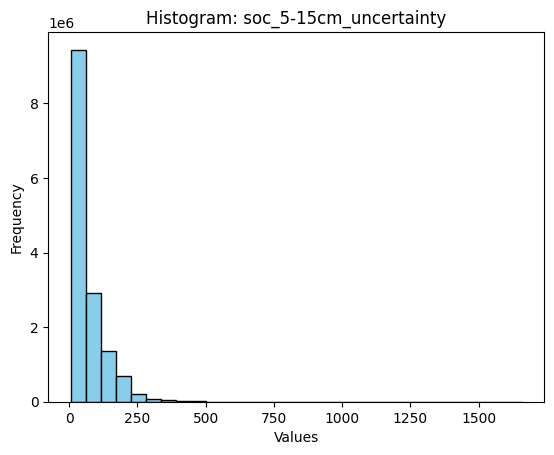

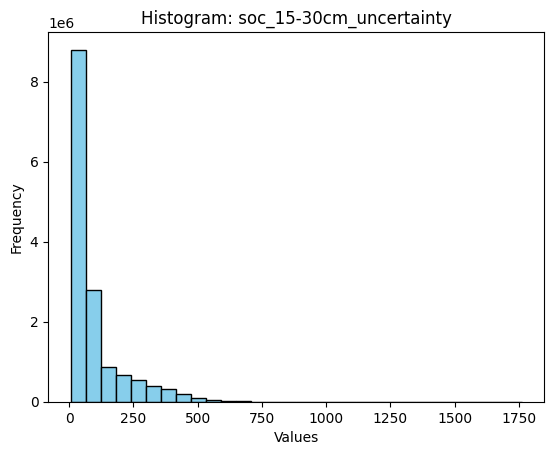

In [12]:
for key, value in np_data_dict_flat.items():
    if 'uncertainty' in key:
        plot_hist(value, key)

Convert reported uncertainty (inter-quartile range / median ratio) to SD

"The additional uncertainty layer displayed at soilgrids.org is the ratio between the inter-quantile range (90% prediction interval width) and the median : (Q0.95-Q0.05)/Q0.50. The values are multiplied by 10 in order to have integers and reduce the size of the datasets."

In [20]:

def iqr_rat_to_sd(mean, iqr_rat):
    return iqr_rat / 10 * mean / (1.645*2)

np_data_dict_flat['soc_0-5cm_sd'] = np.zeros(vec_len)
np_data_dict_flat['soc_5-15cm_sd'] = np.zeros(vec_len)
np_data_dict_flat['soc_15-30cm_sd'] = np.zeros(vec_len)

for i in range(vec_len):
    mean1 = np_data_dict_flat[covs[0]][i]
    iqr_rat1 = np_data_dict_flat[covs[1]][i]
    mean2 = np_data_dict_flat[covs[2]][i]
    iqr_rat2 = np_data_dict_flat[covs[3]][i]
    mean3 = np_data_dict_flat[covs[4]][i]
    iqr_rat3 = np_data_dict_flat[covs[5]][i]
    np_data_dict_flat['soc_0-5cm_sd'][i] = iqr_rat_to_sd(mean1, iqr_rat1)
    np_data_dict_flat['soc_5-15cm_sd'][i] = iqr_rat_to_sd(mean2, iqr_rat2)
    np_data_dict_flat['soc_15-30cm_sd'][i] = iqr_rat_to_sd(mean3, iqr_rat3)


Plot histograms of sd vectors

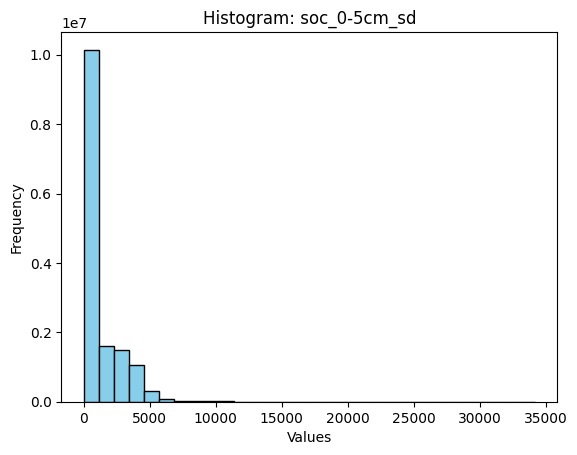

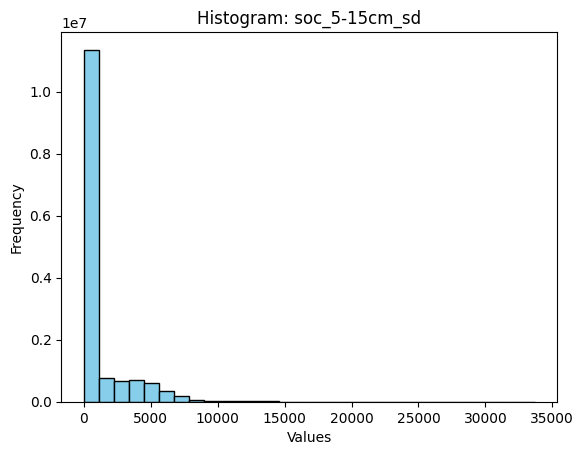

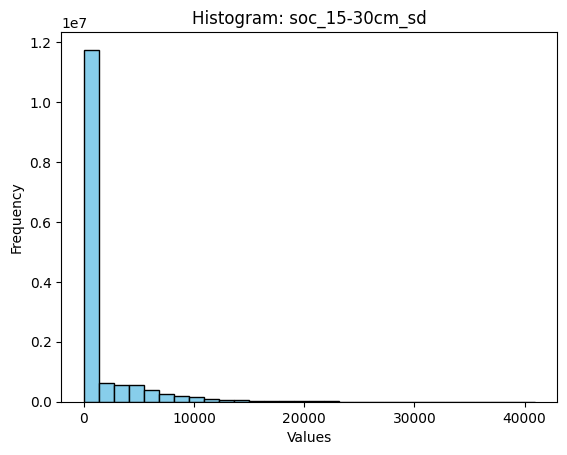

In [22]:
for key, value in np_data_dict_flat.items():
    if 'sd' in key:
        plot_hist(value, key)

Convert SDs to UC percent

In [23]:
def sd_to_uc(mean, sd):
    return (sd * 1.96 / mean) * 100 # 95% CI (90% CI is 1.645)

np_data_dict_flat['soc_0-5cm_uc_pct'] = np.zeros(vec_len)
np_data_dict_flat['soc_5-15cm_uc_pct'] = np.zeros(vec_len)
np_data_dict_flat['soc_15-30cm_uc_pct'] = np.zeros(vec_len)

for i in range(vec_len):
    mean1 = np_data_dict_flat[covs[0]][i]
    sd1 = np_data_dict_flat['soc_0-5cm_sd'][i]
    mean2 = np_data_dict_flat[covs[2]][i]
    sd2 = np_data_dict_flat['soc_5-15cm_sd'][i]
    mean3 = np_data_dict_flat[covs[4]][i]
    sd3 = np_data_dict_flat['soc_15-30cm_sd'][i]
    np_data_dict_flat['soc_0-5cm_uc_pct'][i] = sd_to_uc(mean1, sd1)
    np_data_dict_flat['soc_5-15cm_uc_pct'][i] = sd_to_uc(mean2, sd2)
    np_data_dict_flat['soc_15-30cm_uc_pct'][i] = sd_to_uc(mean3, sd3)


Plot histograms of uncertainty percent vectors

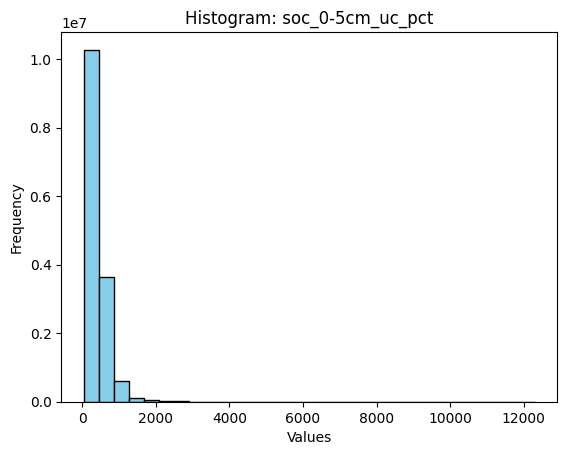

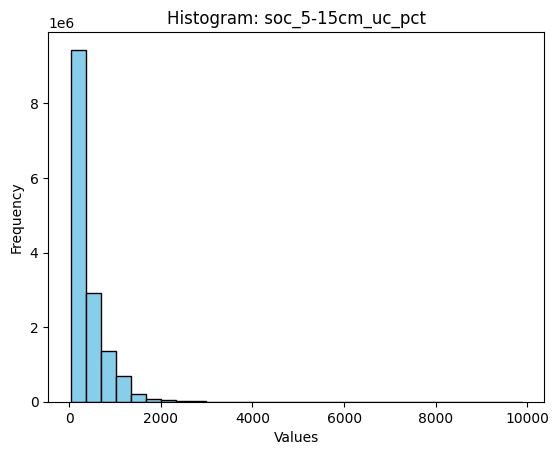

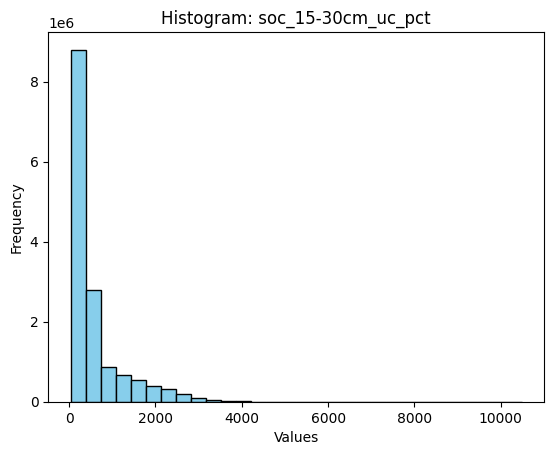

In [25]:
for key, value in np_data_dict_flat.items():
    if 'uc_pct' in key:
        plot_hist(value, key)

Save computed vector data to pickle

In [ ]:
with open("np_data_dict_flat.p", "wb") as file:
    pickle.dump(np_data_dict_flat, file)

Load computed vector data from pickle

In [ ]:
with open('np_data_dict_flat.p', 'rb') as file:
    np_data_dict_flat = pickle.load(file)

Error propagation formula

In [26]:
def add_uc(mean1, uc1, mean2, uc2, mean3, uc3):
    return math.sqrt((uc1*mean1)**2 + (uc2*mean2)**2 + (uc3*mean3)**2) / abs(mean1 + mean2 + mean3)

In [27]:
# testing
add_uc(5,20,4,30,6,10)

11.155467020454342

Calculate propagated uncertainty for each cell

In [28]:
vec_len = 64173720
# vec_len = 5000

comb_uc_vec = np.zeros(vec_len)

for i in range(vec_len):
    mean1 = np_data_dict_flat['soc_0-5cm_mean'][i]
    uc1 = np_data_dict_flat['soc_0-5cm_uc_pct'][i]
    mean2 = np_data_dict_flat['soc_5-15cm_mean'][i]
    uc2 = np_data_dict_flat['soc_5-15cm_uc_pct'][i]
    mean3 = np_data_dict_flat['soc_15-30cm_mean'][i]
    uc3 = np_data_dict_flat['soc_15-30cm_uc_pct'][i]
    comb_uc_vec[i] = add_uc(mean1, uc1, mean2, uc2, mean3, uc3)


Save combined uncertainty data to pickle

In [29]:
with open("comb_uc_vec.p", "wb") as file:
    pickle.dump(comb_uc_vec, file)

Load combined uncertainty data from pickle

In [151]:
with open('comb_uc_vec.p', 'rb') as file:
    comb_uc_vec = pickle.load(file)

Investigate error distribution

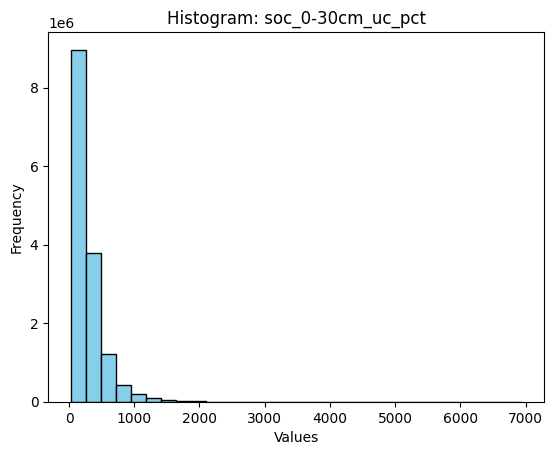

In [30]:
plot_hist(comb_uc_vec, 'soc_0-30cm_uc_pct')

What is the mean uncertainty?

In [42]:
print(np.nanmean(comb_uc_vec))
print(np.nanmedian(comb_uc_vec))

283.81228838627084
204.72744565276432


Convert vector back to 2d array

In [31]:
comb_uc_2d = comb_uc_vec.reshape(4836, 13270)

Plot combined uc data

In [32]:
plot_np_sg(comb_uc_2d, 'soc_0-30cm_uc_pct')

Convert array back to tif

In [33]:
# reset na value
na_val = sg_data_dict['soc_0-5cm_uncertainty']._FillValue # no data value of original rasters is -32768
comb_uc_2d_repnan = np.nan_to_num(comb_uc_2d, nan = na_val)

# use existing tif to get extent and resolution
with rio.open('soc_0-5cm_uncertainty.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
# ras_meta['dtype'] = "int32"
# ras_meta['nodata'] = -32768

# write new data to raster and save
with rio.open('soc_0-30cm_uc_pct.tif', 'w', **ras_meta) as dst:
    dst.write(comb_uc_2d_repnan, 1)